## Test redshift independce

In [1]:
!pip install corner
!pip install -U emcee

In [2]:
%run 00_Dataset.ipynb

In [3]:
import pandas as pd
import numpy as np
import emcee
import corner
import os 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

In [4]:
df_SNe = pd.read_excel('../data/quasar/QuasarDataset.xlsx')


In [5]:
GRB = pd.read_csv(os.path.join('../data/','GRB','GRB_data_Wang_et_al_2011.csv'))
GRB = GRB.sort_values('z', ascending=False)

In [6]:
mu, mu_err = np.genfromtxt(os.path.join(out_dir,"reconstruction.csv"), delimiter=',')

In [7]:
# load the reconstructed data from RNN+BNN for dataset
GRB['mu'] = mu
GRB['mu_err'] =  2. * mu_err

In [8]:
def calculate_dL(mu):
    '''
    dL is the luminosity distance of GRB, which can be obtained from the reconstructed distance moduli of Pantheon
    '''
    
    return 10**((mu-25)/5) * 10**6 * 2.998e+18

def calculate_dL_err(dL, mu_err):

    return abs(dL) * abs(np.log(10) * mu_err / 5.)

def calculate_L(d_L, P_bolo):

    '''
    Assuming that GRBs radiate isotropically, the isotropic equivalent
    luminosity can be derived from bolometric peak flux P_bolo
    '''

    return 4*np.pi*((d_L)**2)*P_bolo

def calculate_L_err(dL_err, dL, P_bolo_err, P_bolo, L):

    return abs(L) * np.sqrt((2. * dL_err / dL)**2 + (P_bolo_err / P_bolo)**2)

def calculate_E_iso(dL, S_bolo, z):
    '''
    The isotropic equivalent energy E_iso can be obtained from the 
    bolometric fluence S_bolo by
    '''

    return 4*np.pi*(dL)**2*S_bolo / (1+z)

def calculate_E_iso_err(L, dL_err, dL, S_bolo_err, S_bolo, z):
    
    return abs(L) * np.sqrt((2. * dL_err / dL)**2 + (S_bolo_err / S_bolo)**2) / (1+z)

def calculate_E_gamma(E_iso, F_beam):
    '''
    If GRBs radiate in two symmetric beams, then we can define the 
    collimation-corrected energy E_gamma as
    '''

    return E_iso * F_beam

def calculate_E_gamma_err(E_iso, F_beam, E_gamma, E_iso_err, F_beam_err):

    return abs(E_gamma) * np.sqrt((E_iso_err / E_iso)**2 + (F_beam_err / F_beam)**2 )

In [9]:
# get distance moduli for redshifts using reconstructed mu-z funciton
GRB['dL'] = calculate_dL(GRB['mu'].to_numpy()) 
GRB['dL_err'] = calculate_dL_err(GRB['dL'].to_numpy(), GRB['mu_err'].to_numpy())
GRB['L'] = calculate_L(GRB['dL'].to_numpy(), GRB['P_bolo'].to_numpy()) 
GRB['L_err'] = calculate_L_err(GRB['dL_err'].to_numpy(), GRB['dL'].to_numpy(), GRB['P_bolo_err'].to_numpy(), GRB['P_bolo'].to_numpy(), GRB['L'].to_numpy()) 
GRB['E_iso'] = calculate_E_iso(GRB['dL'].to_numpy(), GRB['S_bolo'].to_numpy(), GRB['z'].to_numpy())
GRB['E_iso_err'] = calculate_E_iso_err(GRB['L'].to_numpy(), GRB['dL_err'].to_numpy(), GRB['dL'].to_numpy(), GRB['S_bolo_err'].to_numpy(), GRB['S_bolo'].to_numpy(), GRB['z'].to_numpy())
GRB['E_gamma'] = calculate_E_gamma(GRB['E_iso'].to_numpy(), GRB['F_beam'].to_numpy())
GRB['E_gamma_err'] = calculate_E_gamma_err(GRB['E_iso'].to_numpy(), GRB['F_beam'].to_numpy(), GRB['E_gamma'].to_numpy(), GRB['E_iso_err'].to_numpy(), GRB['F_beam_err'].to_numpy())

In [10]:
# Since E_peak, error bars are asymmetric, just take the average of the lower and upper errors and then do the fit.
GRB['E_peak_err'] = GRB[['E_peak_err_min','E_peak_err_max']].mean(axis=1)

In [11]:
GRB['T_lag_i'] = GRB['T_lag'] / (1. + GRB['z'])
GRB['T_lag_i_err'] = GRB['T_lag_err'] / (1. + GRB['z'])

GRB['T_RT_i'] = GRB['T_RT'] / (1. + GRB['z'])
GRB['T_RT_i_err'] = GRB['T_RT_err'] / (1. + GRB['z'])

GRB['V_i'] = GRB['V'] * (1. + GRB['z'])
GRB['V_i_err'] = GRB['V_err'] * (1. + GRB['z'])

GRB['E_peak_i'] = GRB['E_peak'] * (1. + GRB['z'])
GRB['E_peak_i_err'] = GRB['E_peak_err'] * (1. + GRB['z'])
GRB['E_peak_i_err_min'] = GRB['E_peak_err_min'] * (1. + GRB['z'])
GRB['E_peak_i_err_max'] = GRB['E_peak_err_max'] * (1. + GRB['z'])

In [12]:
# normalized
GRB['_T_lag_i'] = GRB['T_lag_i'] / 0.1
GRB['_T_lag_i_err'] = GRB['T_lag_i_err'] / 0.1

GRB['_V_i'] = GRB['V_i'] / 0.02
GRB['_V_i_err'] = GRB['V_i_err'] / 0.02

GRB['_E_peak_i'] = GRB['E_peak_i'] / 300
GRB['_E_peak_i_err'] = GRB['E_peak_i_err'] / 300
GRB['_E_peak_i_err_min'] = GRB['E_peak_i_err_min'] / 300
GRB['_E_peak_i_err_max'] = GRB['E_peak_i_err_max'] / 300

GRB['_T_RT_i'] = GRB['T_RT_i'] / 0.1
GRB['_T_RT_i_err'] = GRB['T_RT_i_err'] / 0.1

In [13]:
# log transformation
GRB['log_T_lag_i'] = np.log10(GRB['_T_lag_i'])
GRB['log_T_lag_i_err'] = abs(GRB['_T_lag_i_err'] / (GRB['_T_lag_i'] * np.log(10)))

GRB['log_V_i'] = np.log10(GRB['_V_i'])
GRB['log_V_i_err'] = abs(GRB['_V_i_err'] / (GRB['_V_i'] * np.log(10)))

GRB['log_E_peak_i'] = np.log10(GRB['_E_peak_i'])
GRB['log_E_peak_i_err'] = abs(GRB['_E_peak_i_err'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_E_peak_i_err_min'] = abs(GRB['_E_peak_i_err_min'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_E_peak_i_err_max'] = abs(GRB['_E_peak_i_err_max'] / (GRB['_E_peak_i'] * np.log(10)))

GRB['log_T_RT_i'] = np.log10(GRB['_T_RT_i'])
GRB['log_T_RT_i_err'] = abs(GRB['_T_RT_i_err'] / (GRB['_T_RT_i'] * np.log(10)))

c:\Users\Sarvesh Purohit\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Sarvesh Purohit\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
GRB['log_L'] = np.log10(GRB['L'])
GRB['log_L_err'] = abs(GRB['L_err'] / (GRB['L'] * np.log(10)))

GRB['log_E_iso'] = np.log10(GRB['E_iso'])
GRB['log_E_iso_err'] = abs(GRB['E_iso_err'] / (GRB['E_iso'] * np.log(10)))

GRB['log_E_gamma'] = np.log10(GRB['E_gamma'])
GRB['log_E_gamma_err'] = abs(GRB['E_gamma_err'] / (GRB['E_gamma'] * np.log(10)))

In [15]:
# split the data in to low-z, high-z and All-z
low_z_GRB = GRB[GRB['z']<=1.4]
high_z_GRB = GRB[GRB['z']>1.4]
All_z_GRB = GRB

In [16]:
low_z_GRB.shape,high_z_GRB.shape,All_z_GRB.shape,

((50, 64), (66, 64), (116, 64))

In [17]:
# filter GRBs seperately for each correlation, such that required data are present for each GRB
 

In [18]:
def log_likelihood(theta, x, y, xerr, yerr):
    b, a, sigma_int = theta
    model = b * x + a
    sigma2 = sigma_int**2 + yerr**2 + b**2 * xerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    b, a, sigma_int = theta
    if sigma_int > 0:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

In [19]:
# plt.rc('text', usetex=True)

# plt.rcParams.update({
#     'text.usetex' : True
# })

In [20]:
# import matplotlib

In [21]:
# preamble = '\n'.join([r"\usepackage{lmodern}", r"\usepackage{tikz}"])
# params = {'text.latex.preamble': preamble,
#           'text.usetex': True,
#           'font.size': 8,
#           'font.family': 'lmodern'}
# matplotlib.rcParams.update(params)

Name: T_lag-L
Index(['log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'], dtype='object')
low-z samples (27, 4)


  3%|▎         | 168/5000 [00:00<00:08, 571.41it/s]

100%|██████████| 5000/5000 [00:07<00:00, 680.19it/s]


Index(['log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'], dtype='object')
high-z samples (32, 4)


100%|██████████| 5000/5000 [00:07<00:00, 663.05it/s]


Index(['log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'], dtype='object')
All-z samples (59, 4)


100%|██████████| 5000/5000 [00:07<00:00, 664.01it/s]
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\2622471501.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


Name: V-L
Index(['log_V_i', 'log_E_iso', 'log_V_i_err', 'log_E_iso_err'], dtype='object')
low-z samples (37, 4)


100%|██████████| 5000/5000 [00:06<00:00, 744.71it/s]


Index(['log_V_i', 'log_E_iso', 'log_V_i_err', 'log_E_iso_err'], dtype='object')
high-z samples (52, 4)


100%|██████████| 5000/5000 [00:06<00:00, 731.57it/s]


Index(['log_V_i', 'log_E_iso', 'log_V_i_err', 'log_E_iso_err'], dtype='object')
All-z samples (89, 4)


100%|██████████| 5000/5000 [00:07<00:00, 648.68it/s]
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\2622471501.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


Name: E_peak-L
Index(['log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'], dtype='object')
low-z samples (50, 4)


100%|██████████| 5000/5000 [00:10<00:00, 478.74it/s]


Index(['log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'], dtype='object')
high-z samples (66, 4)


100%|██████████| 5000/5000 [00:06<00:00, 753.18it/s]


Index(['log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'], dtype='object')
All-z samples (116, 4)


100%|██████████| 5000/5000 [00:06<00:00, 738.90it/s]
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\2622471501.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


Name: E_peak-E_gamma
Index(['log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'], dtype='object')
low-z samples (12, 4)


100%|██████████| 5000/5000 [00:07<00:00, 643.23it/s]


Index(['log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'], dtype='object')
high-z samples (12, 4)


100%|██████████| 5000/5000 [00:08<00:00, 570.68it/s]


Index(['log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'], dtype='object')
All-z samples (24, 4)


100%|██████████| 5000/5000 [00:09<00:00, 523.08it/s]
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\2622471501.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


Name: T_RT-L
Index(['log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'], dtype='object')
low-z samples (39, 4)


100%|██████████| 5000/5000 [00:07<00:00, 668.83it/s]


Index(['log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'], dtype='object')
high-z samples (40, 4)


100%|██████████| 5000/5000 [00:06<00:00, 795.97it/s]


Index(['log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'], dtype='object')
All-z samples (79, 4)


100%|██████████| 5000/5000 [00:05<00:00, 840.16it/s]
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\2622471501.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


Name: E_peak-E_iso
Index(['log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err'], dtype='object')
low-z samples (40, 4)


100%|██████████| 5000/5000 [00:05<00:00, 855.20it/s]


Index(['log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err'], dtype='object')
high-z samples (61, 4)


100%|██████████| 5000/5000 [00:06<00:00, 821.48it/s]


Index(['log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err'], dtype='object')
All-z samples (101, 4)


100%|██████████| 5000/5000 [00:07<00:00, 627.71it/s]
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\2622471501.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


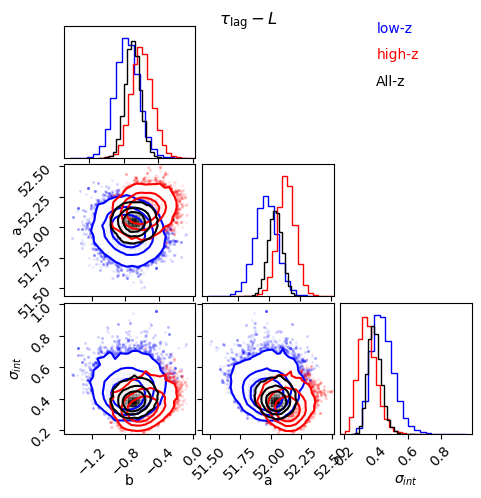

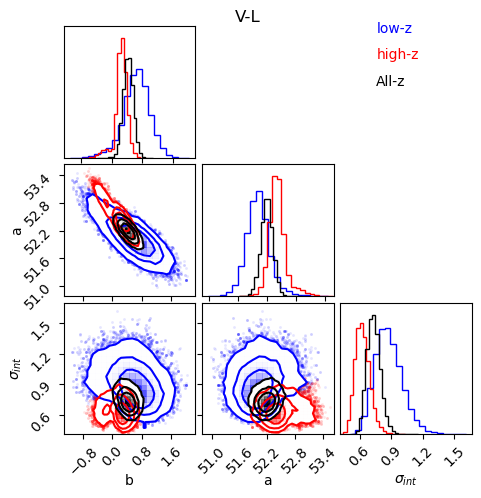

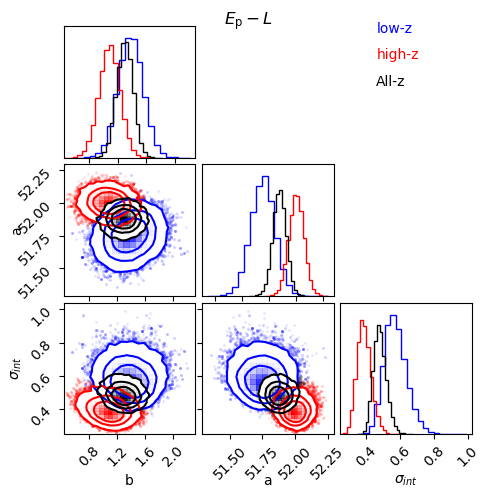

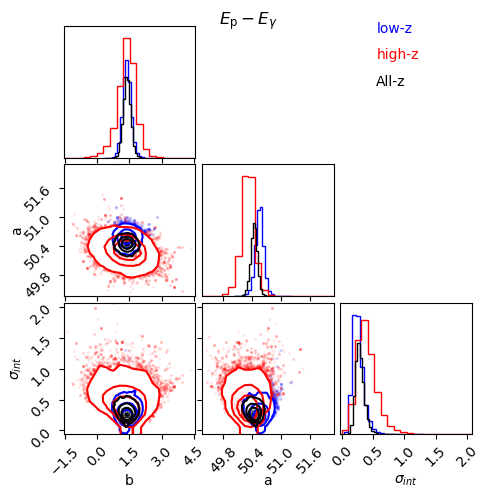

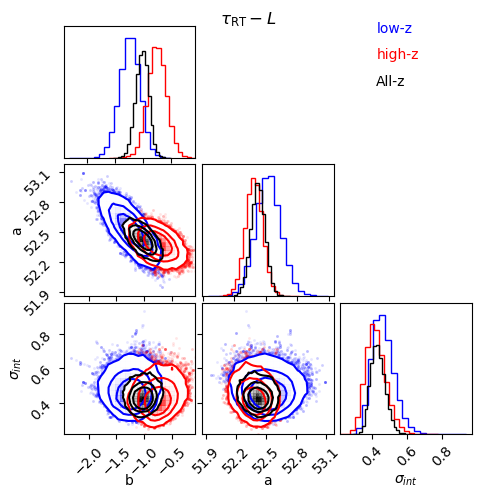

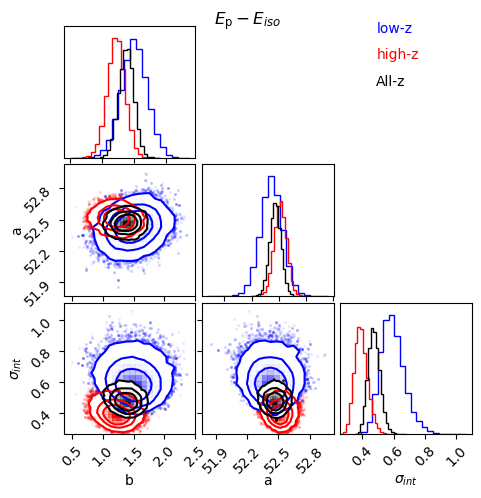

In [22]:
correlations = {
    'T_lag-L' : ('log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'),
    'V-L' : ('log_V_i', 'log_E_iso', 'log_V_i_err', 'log_E_iso_err'),
    'E_peak-L' : ('log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'),
    'E_peak-E_gamma' : ('log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'),
    'T_RT-L' : ('log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'),
    'E_peak-E_iso' : ('log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err')
}

# Calculate best fit line with uncertainities(Bayesian approach) using emcee
GRB_samples = (low_z_GRB, high_z_GRB, All_z_GRB)
sample_types =  ('low-z', 'high-z', 'All-z')
colors = ('b','r','k')

# MCMC parameters
nwalkers, ndim = 32, 3
nsteps, nburns = 5000, 1000

# empty dictionary to save best fit parameters and uncertainities
BestFitParameters = { 
    'T_lag-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'V-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'E_peak-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'E_peak-E_gamma':{'low-z':None, 'high-z':None, 'All-z':None},
    'T_RT-L':{'low-z':None, 'high-z':None, 'All-z':None},
    'E_peak-E_iso':{'low-z':None, 'high-z':None, 'All-z':None}
}

num = 8
for i, correlation in enumerate(correlations):
    print("Name:",correlation)
    luminosities = correlations[correlation]

    # create empty figure object for corner plots (confidence contours and marginalized PDFs of parameters)
    fig2 = plt.figure(figsize=(5, 5))
    fig2.patch.set_facecolor('white')

    for k, (GRB_sample, sample_type, color) in enumerate(zip(GRB_samples, sample_types, colors)):

        df = GRB_sample.filter(luminosities).dropna()
        print(df.columns)
        print(sample_type,"samples",df.shape)
        x = df[luminosities[0]].to_numpy()
        y = df[luminosities[1]].to_numpy()
        xerr = df[luminosities[2]].to_numpy()
        yerr = df[luminosities[3]].to_numpy()

        starting_guesses = np.random.rand(nwalkers, ndim)
        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, xerr, yerr))
        sampler.run_mcmc(starting_guesses, nsteps, progress=True)

        labels = ['b', 'a', '$\sigma_{int}$']
        '''
        # time series plot of parameters
        samples = sampler.get_chain()
        gs11 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs1[k])

        for j in range(ndim):
            ax = fig1.add_subplot(gs11[j])
            ax.plot(samples[..., j], 'k', alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[j])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        #axes[-1].set_xlabel("step number");
        '''
        # corner plots
        flat_samples = sampler.get_chain(discard=nburns, flat=True)
        corner.corner(flat_samples, labels=labels, color=color,fig=fig2,levels=(0.68,0.90,0.99,))

        # save best fit values(mean) and uncertainities(std) of parameters in a dictionary
        BestFitParameters[correlation][sample_type] = {
                'a' : np.mean(flat_samples[:, 1]), 
                'a_err' : np.std(flat_samples[:, 1]),
                'b' : np.mean(flat_samples[:, 0]), 
                'b_err' : np.std(flat_samples[:, 0]),
                'sigma_int' : np.mean(flat_samples[:, 2]),
                'sigma_int_err' : np.std(flat_samples[:, 2])
        }
    
        fig2.axes[0].annotate(sample_type, xy=(0.95*2.5, 0.95-k*0.2), xycoords='axes fraction',color=color)
  
    # fig2.suptitle(r"$T_{lag}-L$")
    # fig2.suptitle(correlation)
    # fig2.suptitle(r'$T_{\mathrm{lag}-L}$')
    if(correlation=="T_lag-L"):
        fig2.suptitle(r'$\tau_{\mathrm{lag}}-L$')

    if(correlation=="V-L"):
        fig2.suptitle(r'V-L')
    
    if(correlation=="E_peak-L"):
        fig2.suptitle(r'$E_{\mathrm{p}} - L$')
    
    if(correlation=="E_peak-E_gamma"):
        fig2.suptitle(r'$E_{\mathrm{p}} - E_{\gamma}$')
    
    if(correlation=="T_RT-L"):
        fig2.suptitle(r'$\tau_{\mathrm{RT}} - L$')
    
    if(correlation=="E_peak-E_iso"):
        fig2.suptitle(r'$E_{\mathrm{p}} - E_{iso}$')
    
    
    #fig1.savefig('time_series_of_params.pdf')
    num_str = '0' + str(num) if num < 10 else str(num)
    fig2.savefig(os.path.join(out_dir, num_str+'_'+correlation+'_corner_plot.pdf'))
    num += 1
    #fig1.show()
    fig2.show()
    


In [23]:
with open(os.path.join(out_dir, 'BestFitParameters.pickle'), 'wb') as handle:
    pickle.dump(BestFitParameters, handle)

In [24]:
with open(os.path.join(out_dir, 'BestFitParameters.pickle'), 'rb') as handle:
    BestFitParameters = pickle.load(handle)

In [25]:
BestFitParameters

{'T_lag-L': {'low-z': {'a': 51.971848339997635,
   'a_err': 0.09056809994638741,
   'b': -0.765295981532408,
   'b_err': 0.13577951221354867,
   'sigma_int': 0.4416061627449643,
   'sigma_int_err': 0.0713316955697717},
  'high-z': {'a': 52.13647233701837,
   'a_err': 0.07018740756144652,
   'b': -0.5941803613422287,
   'b_err': 0.12169034403644567,
   'sigma_int': 0.34593797194177583,
   'sigma_int_err': 0.05702465854200375},
  'All-z': {'a': 52.044544432101354,
   'a_err': 0.055088218835622794,
   'b': -0.6963423953757706,
   'b_err': 0.08757701141253056,
   'sigma_int': 0.3894816820926485,
   'sigma_int_err': 0.042801195477481645}},
 'V-L': {'low-z': {'a': 52.00107734747701,
   'a_err': 0.23964250387533412,
   'b': 0.6286702213314117,
   'b_err': 0.3550361231016561,
   'sigma_int': 0.8775153783030507,
   'sigma_int_err': 0.1300691065451251},
  'high-z': {'a': 52.40693686979088,
   'a_err': 0.18053572179668095,
   'b': 0.24643275200723735,
   'b_err': 0.17047442549731728,
   'sigma_in

In [26]:
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

table = nested_dict_to_df(BestFitParameters)

!pip install tabulate

from tabulate import tabulate

print(tabulate(table, headers='keys', tablefmt='fancy_grid'))

╒══════════════════════════════╤═════════╤═══════════╤═══════════╤══════════╤═════════════╤═════════════════╕
│                              │       a │     a_err │         b │    b_err │   sigma_int │   sigma_int_err │
╞══════════════════════════════╪═════════╪═══════════╪═══════════╪══════════╪═════════════╪═════════════════╡
│ ('E_peak-E_gamma', 'All-z')  │ 50.4344 │ 0.069613  │  1.39175  │ 0.17232  │    0.286321 │       0.0709314 │
├──────────────────────────────┼─────────┼───────────┼───────────┼──────────┼─────────────┼─────────────────┤
│ ('E_peak-E_gamma', 'high-z') │ 50.3036 │ 0.136749  │  1.36921  │ 0.438172 │    0.396544 │       0.162871  │
├──────────────────────────────┼─────────┼───────────┼───────────┼──────────┼─────────────┼─────────────────┤
│ ('E_peak-E_gamma', 'low-z')  │ 50.5473 │ 0.0894291 │  1.38588  │ 0.203079 │    0.259063 │       0.0898273 │
├──────────────────────────────┼─────────┼───────────┼───────────┼──────────┼─────────────┼─────────────────┤
│ ('E_peak

C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\481421005.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\481421005.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\481421005.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\481421005.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Sarvesh Purohit\AppData\Local\Temp\ipykernel_7144\481421005.py:87: User

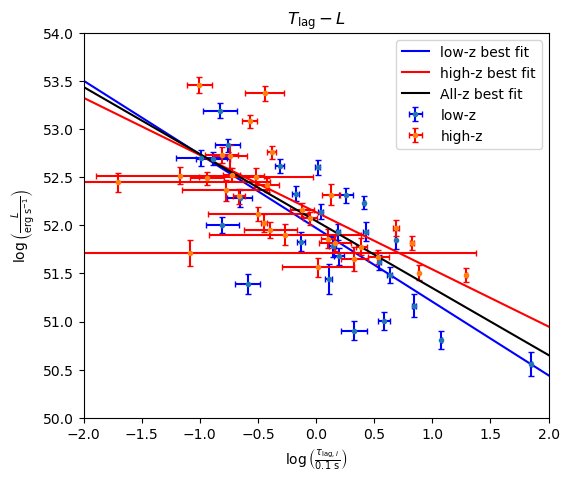

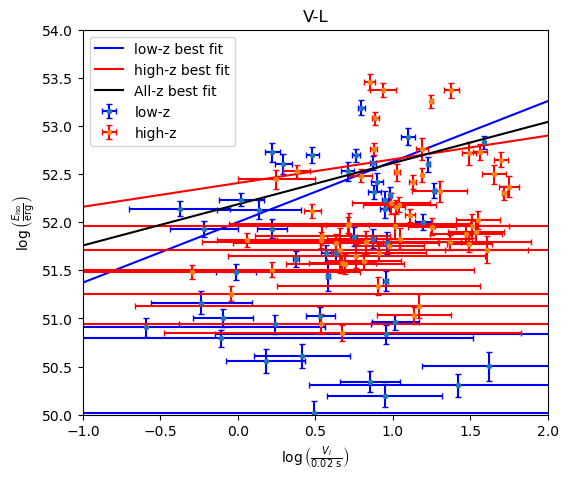

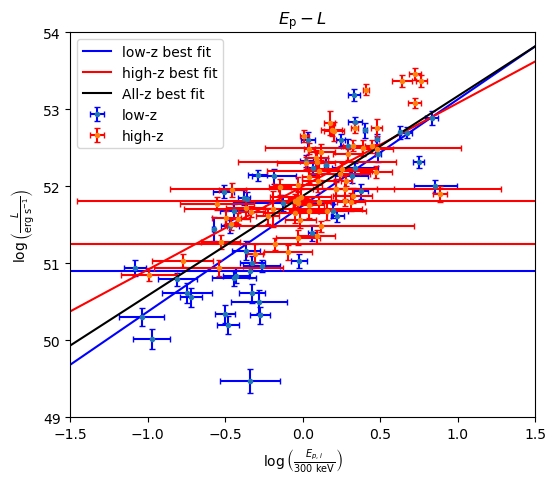

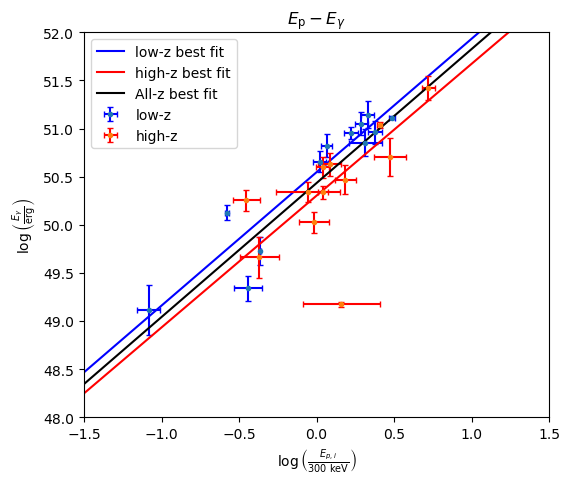

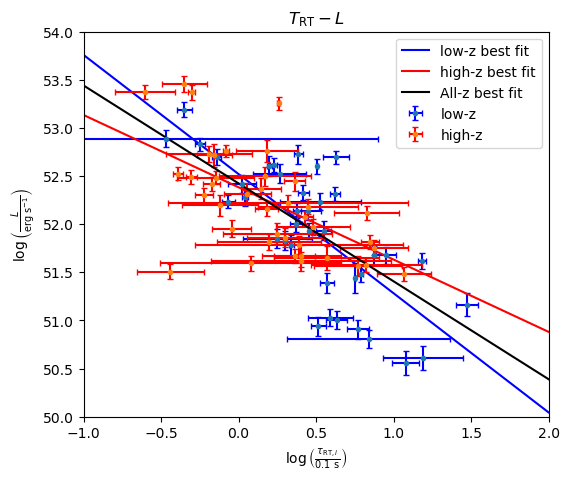

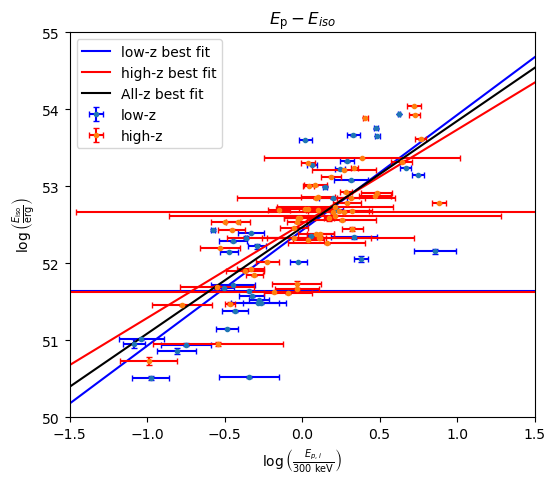

In [36]:
correlations = {
    'T_lag-L' : {'features': ('log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'), 'ylim':(50, 54), 'xlim':(-2.0,2.0)},
    'V-L' : {'features': ('log_V_i', 'log_L', 'log_V_i_err', 'log_L_err'), 'ylim':(50, 54), 'xlim':(-1.0,2.0)},
    'E_peak-L' : {'features': ('log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'), 'ylim':(49, 54), 'xlim':(-1.5,1.5)},
    'E_peak-E_gamma' : {'features': ('log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'), 'ylim':(48, 52), 'xlim':(-1.5,1.5)},
    'T_RT-L' : {'features': ('log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'), 'ylim':(50, 54), 'xlim':(-1.0,2.0)},
    'E_peak-E_iso' : {'features': ('log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err'), 'ylim':(50, 55), 'xlim':(-1.5,1.5)}
}

GRB_samples = (low_z_GRB, high_z_GRB, All_z_GRB)
sample_types =  ('low-z', 'high-z', 'All-z')
colors = ('b','r','k')


# plot best fit for each luminosity correlation
for i, correlation in enumerate(correlations):
    
    fig, ax = plt.subplots(figsize=(6, 5))
    fig.patch.set_facecolor('white')

    luminosities = correlations[correlation]['features']

    # create empty figures with no axis
    #plt.figure(figsize=(15,5))

    #plt.subplot(121)

    for GRB_sample, sample_type, color in zip(GRB_samples, sample_types, colors):
        
        df = GRB_sample.filter(luminosities).dropna()
            
        x = df[luminosities[0]].to_numpy()
        y = df[luminosities[1]].to_numpy()
        xerr = df[luminosities[2]].to_numpy()
        yerr = df[luminosities[3]].to_numpy()

        if sample_type != 'All-z':
            (_, caps, _) = ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.', ecolor=color, label=sample_type,capsize=2)
            for cap in caps:
                cap.set_markeredgewidth(1)
        
        ax.plot(
            np.linspace(-2,2,100), 
            BestFitParameters[correlation][sample_type]['a'] + BestFitParameters[correlation][sample_type]['b'] * np.linspace(-2,2,100),
            #luminosity_correlation_fit(np.linspace(-2,2,100), 'T_lag-L', sample_type), 
            linestyle='-', color=color, label=sample_type +' best fit'
            )

    if(correlation=="T_lag-L"):
        ax.set_title(r'$T_{\mathrm{lag}}-L$')
        ax.set_ylabel(r'$\log\left(\frac{L}{\mathrm{erg\ s^{-1}}}\right)$', fontsize=10)
        ax.set_xlabel(r'$\log\left(\frac{\tau_{\mathrm{lag},i}}{0.1\ \mathrm{s}}\right)$', fontsize=10)

    if(correlation=="V-L"):
        ax.set_title(r'V-L')
        ax.set_xlabel(r'$\log\left(\frac{V_i}{0.02\ \mathrm{s}}\right)$', fontsize=10)
        ax.set_ylabel(r'$\log\left(\frac{E_{\mathrm{iso}}}{\mathrm{erg}}\right)$', fontsize=10)
    
    if(correlation=="E_peak-L"):
        ax.set_title(r'$E_{\mathrm{p}} - L$')
        ax.set_xlabel(r'$\log\left(\frac{E_{p,i}}{300\ \mathrm{keV}}\right)$', fontsize=10)
        ax.set_ylabel(r'$\log\left(\frac{L}{\mathrm{erg\ s^{-1}}}\right)$', fontsize=10)
    
    if(correlation=="E_peak-E_gamma"):
        ax.set_title(r'$E_{\mathrm{p}} - E_{\gamma}$')
        ax.set_xlabel(r'$\log\left(\frac{E_{p,i}}{300\ \mathrm{keV}}\right)$', fontsize=10)
        ax.set_ylabel(r'$\log\left(\frac{E_{\gamma}}{\mathrm{erg}}\right)$', fontsize=10)
    
    if(correlation=="T_RT-L"):
        ax.set_title(r'$T_{\mathrm{RT}} - L$')
        ax.set_xlabel(r'$\log\left(\frac{\tau_{\mathrm{RT},i}}{0.1\ \mathrm{s}}\right)$', fontsize=10)
        ax.set_ylabel(r'$\log\left(\frac{L}{\mathrm{erg\ s^{-1}}}\right)$', fontsize=10)
    
    if(correlation=="E_peak-E_iso"):
        ax.set_title(r'$E_{\mathrm{p}} - E_{iso}$')
        ax.set_xlabel(r'$\log\left(\frac{E_{p,i}}{300\ \mathrm{keV}}\right)$', fontsize=10)
        ax.set_ylabel(r'$\log\left(\frac{E_{\mathrm{iso}}}{\mathrm{erg}}\right)$', fontsize=10) 
    
    # ax.set_xlabel(luminosities[0])
    # ax.set_ylabel(luminosities[1])
    ax.set_ylim(correlations[correlation]['ylim'])
    ax.set_xlim(correlations[correlation]['xlim'])
        
    ax.legend()

    plt.savefig(os.path.join(out_dir,'15_'+correlation+'.pdf'))
    fig.show()

In [28]:
# Save GRB with all the fields to csv, to be used in computation
GRB.to_csv(os.path.join(out_dir,'GRB_'+dataset+'.csv'))